## Battery storage optimization

We would need a load standard profile, a few packages like pandas and numpy for data analysis and of course gurobi for the optimization.

In [5]:
%run installation.py

demandlib is installed
workalendar is installed
gurobi is installed


In [6]:
# import necessary packages
import demandlib.bdew as bdew
import pandas as pd
import numpy as np

Let us first import the standard load profile.

In [7]:
import os

# Get the current working directory (cwd)
cwd = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(cwd)

# Get the grandparent directory
grandparent_dir = os.path.dirname(parent_dir)

In [8]:
# read standard load profiles
e_slp = bdew.ElecSlp(2021)

# multiply given annual demand with timeseries
elec_demand = e_slp.get_profile(ann_el_demand_per_sector= {"h0_dyn": 13000})

elec_demand_resampled = elec_demand.resample("H").mean()
elec_demand_list = elec_demand_resampled['h0_dyn']

# Define the file path
file = 'exercise_2/data/TRY_507755060854/TRY2015_507755060854_Jahr.dat'
file_path = os.path.join(grandparent_dir, file)


# Define the column names based on the structure
columns = ['RW', 'HW', 'MM', 'DD', 'HH', 't', 'p', 'WR', 'WG', 'N', 'x', 'RF', 'B', 'D', 'A', 'E', 'IL']

# Read the .dat file into a DataFrame
data = pd.read_csv(file_path, skiprows=34, sep='\s+', names=columns)
data.index = pd.date_range(start='2015-01-01 00:00',
                           end='2015-12-31 23:00', freq='H')


sum_bd = data['B'] + data['D'] # sum of direct and diffuse solar power
sum_bd_list = sum_bd.tolist()

Now we have to compute the PV hourly radiation, but we can also plot the residual load:

$$ P_{\text{residual load}} = P_{load} - P_{PV} $$

<AxesSubplot: title={'center': 'residual load'}>

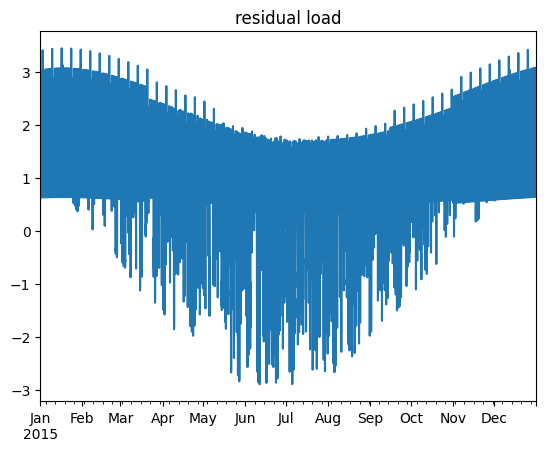

In [9]:
hourly_radiation = pd.DataFrame(data = sum_bd_list, index = data.index)

PV_hourly_radiation = 23.41 * 0.215 * hourly_radiation / 1000
PV_hourly_radiation_list = pd.Series(PV_hourly_radiation[0].tolist())
PV_hourly_radiation_list.index = data.index

difference = pd.Series([x - y for x, y in zip(elec_demand_list, PV_hourly_radiation_list)])
difference.index = data.index
difference.plot(title="residual load")

We can also run a small heuristic to check, when we would expect the battery to charge.

In [10]:
# approx. Datas
count = 0

batt_max = 0
batt_state = 0
grid_energy = 0

# MAX. self-consumption (Heuristic) 
for count in range(0,8760):
    if difference[count] <= 0:
        if batt_state == 0:
            grid_energy += np.abs(difference[count])
        else:
            if np.abs(difference[count]) <= batt_state:
                batt_state -= np.abs(difference[count])
            else:
                grid_energy += (np.abs(difference[count]) - batt_state)
                batt_state == 0
    else:
        batt_state += np.abs(difference[count])
        batt_max = max(batt_max, batt_state)   
        #print (f"{difference[count]},{batt_state},{batt_max}")    

print (f"{batt_max}")
p_char = max(difference)
p_disc = min(difference)
self_cons = sum(PV_hourly_radiation_list)/sum(elec_demand_list)
print (self_cons)

7759.830707495851
0.4030954552700148


Let us now define the problem data again, for an easier and faster computation, we could reduce the temporal resolution down to one week in June.

In [11]:
import numpy as np

electricity_demand = elec_demand_list.to_numpy()
PV_generation = PV_hourly_radiation_list.to_numpy()

reduce_complexity = True

if reduce_complexity:

    number_of_days_to_optimize = 7
    
    # Define the indices for the 1st of June
    start_index = 24 * (31 + 28 + 31 + 30)  # Indices for previous months
    end_index = start_index + 24 * number_of_days_to_optimize # Indices for the 1st of June (24 hours)

    # Extract the data for the 1st of June
    electricity_demand = electricity_demand[start_index:end_index]
    PV_generation = PV_generation[start_index:end_index]

We can inspect the data in a plot:

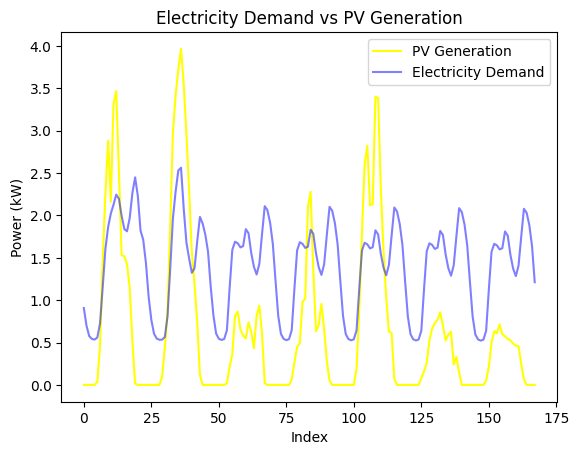

In [12]:
import matplotlib.pyplot as plt

def plot_electricity_pv(electricity_demand, PV_generation):
    # Create an array of indices
    indices = range(len(electricity_demand))
    
    # Plot PV generation in yellow
    plt.plot(indices, PV_generation, color='yellow', label='PV Generation')

    # Plot electricity demand in blue
    plt.plot(indices, electricity_demand, color='blue', label='Electricity Demand', alpha=0.5)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Power (kW)')
    plt.title('Electricity Demand vs PV Generation')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

plot_electricity_pv(electricity_demand, PV_generation)

Next, we have to define the problem data. We use data from online sources for the battery.

https://github.com/Skoltech-PACO/LinearBatteryModels/blob/main/BESS_data_random.csv

In [13]:
# Define the problem data
life_time = 30
interest_rate = 0.05
power_price = 200
battery_offset = 10
capacity_price = 10

el_price = 0.39
feed_in_tariff = 0.09

BESS_data = {
    "PcMax" : 18.71,
    "PdMax" : 11.17,
    "eta_c" : 0.86,
    "eta_d" : 0.77,
    "eta_st" : 0.99,
    "Emax" : 60.6,
    "Emin" : 17.35,
    "E0" : 39.98,
    "SOC_max" : 0.9
}

In [14]:
import gurobipy as gp

from set_gurobi_key import set_gurobi_key, retrieve_wls_gurobi_license
gurobi_license = retrieve_wls_gurobi_license()
set_gurobi_key(gurobi_license)

Set parameter WLSAccessID


Set parameter WLSSecret
Set parameter LicenseID to value 949857
Set parameter WLSAccessID
Set parameter WLSSecret
Academic license 949857 - for non-commercial use only - registered to st___@rwth-aachen.de


This optimization problem represents the cost optimization of a home storage system. The goal is to determine the optimal size and power capacity of the battery for the system, considering the balance between the electricity demand, PV generation, and grid interactions. The problem is formulated using the Gurobi optimization package.

The decision variables in this problem are:

- xbat_max_size​: The installed battery size in kilowatt-hours (kWh).
- xbat_max_power​: The installed battery power capacity in kilowatts (kW).
- electricity_from_grid: The electricity flow from the grid to the demand.
- electricity_to_grid: The electricity flow from the PV system to the grid.
- electricity_to_batt: The electricity flow from the PV system to the battery.
- electricity_from_batt: The electricity flow from the battery to the demand.
- electricity_from_pv: The electricity flow from the PV system to the demand.
- Ebat​: The stored energy in the battery.
- bin_char_bat: Binary variable indicating the charging state of the battery.
- bin_dischar_bat: Binary variable indicating the discharging state of the battery.

The objective of the optimization problem is to minimize the total cost, which consists of the capital expenditure (CAPEX) and the operational expenditure (OPEX). The CAPEX represents the cost associated with the battery installation, and the OPEX represents the cost related to the electricity exchanged with the grid. The objective function is defined as the sum of the CAPEX and OPEX, and it is minimized.

The problem includes several constraints. The flow balance constraint ensures that the total electricity from PV, battery, and the grid equals the electricity demand. The PV generation balance constraint ensures that the total electricity from PV, battery, and the grid equals the PV generation. The battery power restrictions limit the electricity flows to and from the battery based on the installed power capacity. The charging and discharging mutual exclusivity constraint ensures that the battery can either charge or discharge at a given time. The storage losses constraint models the energy losses in the battery due to storage inefficiencies. The battery size restriction ensures that the maximum battery size is not exceeded based on the state of charge (SOC) limits.

Additionally, the problem considers the net present value factor (pvf) to account for the time value of money. It calculates the present value factor based on the lifetime and interest rate provided. The present value factor is used to adjust the CAPEX component of the objective function.

The optimization problem is solved using the Gurobi solver. If an optimal solution is found, it prints the recommended battery size and power capacity. If the problem is infeasible, it computes the Infeasible Inference System (IIS) and generates an infeasible report. Otherwise, if no solution is found, it indicates that there is no feasible solution to the problem.


In [15]:
#################################################
#cost optimization
model = gp.Model("Battery cost optimization")

x_bat_max_size          = model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="bat_kWh_installed")
x_bat_max_power         = model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="bat_kW_installed")

electricity_from_grid   = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="electricity_from_grid_to_demand")
electricity_to_grid     = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="electricity_from_pv_to_grid_feed_in")
electricity_to_batt     = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=BESS_data["PcMax"], name="electricity_from_pv_to_battery")
electricity_from_batt   = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=BESS_data["PdMax"], name="electricity_from_battery_to_demand")
electricity_from_pv     = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="electricity_from_pv_to_demand")
E_bat                   = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=BESS_data["Emin"], ub=BESS_data["Emax"], name="stored energy in bat")

bin_char_bat            = model.addVars(len(electricity_demand), vtype=gp.GRB.BINARY, lb=0, ub=1, name="charging_on")
bin_dischar_bat         = model.addVars(len(electricity_demand), vtype=gp.GRB.BINARY, lb=0, ub=1, name="discharging_on")
 
for i in range(len(electricity_demand)):
    
    #flow balance of the ele. demand
    model.addConstr(electricity_from_pv[i] + electricity_from_batt[i] + electricity_from_grid[i] == electricity_demand[i])
    
    #pv-generation balance  
    model.addConstr(electricity_from_pv[i] + electricity_to_batt[i] + electricity_to_grid[i] == PV_generation[i])
    
    # battery power restrictions
    model.addConstr(electricity_to_batt[i] <= x_bat_max_power * bin_char_bat[i]) 
    model.addConstr(electricity_from_batt[i] <= x_bat_max_power * bin_dischar_bat[i]) 
    
    model.addConstr(bin_char_bat[i] + bin_dischar_bat[i] <= 1)
    
    #storage losses
    if i == 0 : 
        model.addConstr(E_bat[i] == BESS_data["E0"])
    elif i == len(electricity_demand)-1:
        model.addConstr(E_bat[i] == BESS_data["E0"])
    else:
        model.addConstr(E_bat[i] == E_bat[i-1] * BESS_data["eta_st"] + electricity_to_batt[i] * BESS_data["eta_c"] - electricity_from_batt[i] / BESS_data["eta_d"])
        #battery size restriction
    
    model.addConstr(x_bat_max_size >= E_bat[i] / BESS_data["SOC_max"])

## Net present value factor

def present_value_factor(T: int, interest_rate: float):
    return ((1+interest_rate)**T - 1) / ((1+interest_rate)**T * interest_rate)

pvf = present_value_factor(life_time, interest_rate)

# Objective functions
obj = {}
obj["CAPEX"] = (x_bat_max_size * capacity_price + x_bat_max_power * power_price + battery_offset) / pvf
obj["OPEX"] = gp.quicksum(electricity_from_grid[b] * el_price - electricity_to_grid[b] * feed_in_tariff for b in range(len(electricity_demand)))

model.setObjective(obj["CAPEX"] + obj["OPEX"], gp.GRB.MINIMIZE)

model.update()
model.optimize()

if model.status == gp.GRB.OPTIMAL:
    print(f"Battery with {x_bat_max_power.X} kW and {x_bat_max_size.X} kWh should be installed.")
elif model.status == gp.GRB.INFEASIBLE:
    print("The model is infeasible.")
    model.computeIIS()  # Compute the Infeasible Inference System

    # Generate the infeasible report
    model.write("infeasible_report.ilp")  # Save the report to a file
    print("Infeasible report generated: infeasible_report.ilp")
else:
    print("No solution found.")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 949857
Academic license 949857 - for non-commercial use only - registered to st___@rwth-aachen.de


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 949857 - for non-commercial use only - registered to st___@rwth-aachen.de
Optimize a model with 840 rows, 1346 columns and 2346 nonzeros
Model fingerprint: 0xb57c5b76
Model has 336 quadratic constraints
Variable types: 1010 continuous, 336 integer (336 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [9e-02, 1e+01]
  Bounds range     [1e+00, 6e+01]
  RHS range        [2e-02, 4e+01]
Presolve removed 261 rows and 588 columns
Presolve time: 0.01s
Presolved: 1398 rows, 1577 columns, 3415 nonzeros
Presolved model has 546 SOS constraint(s)
Variable types: 1031 continuous, 546 integer (546 binary)
Found heuristic solution: objective 137

In [16]:
# Specify the filename for the output file
output_filename = "model.lp"

# Write the model to the output file
model.write(output_filename)

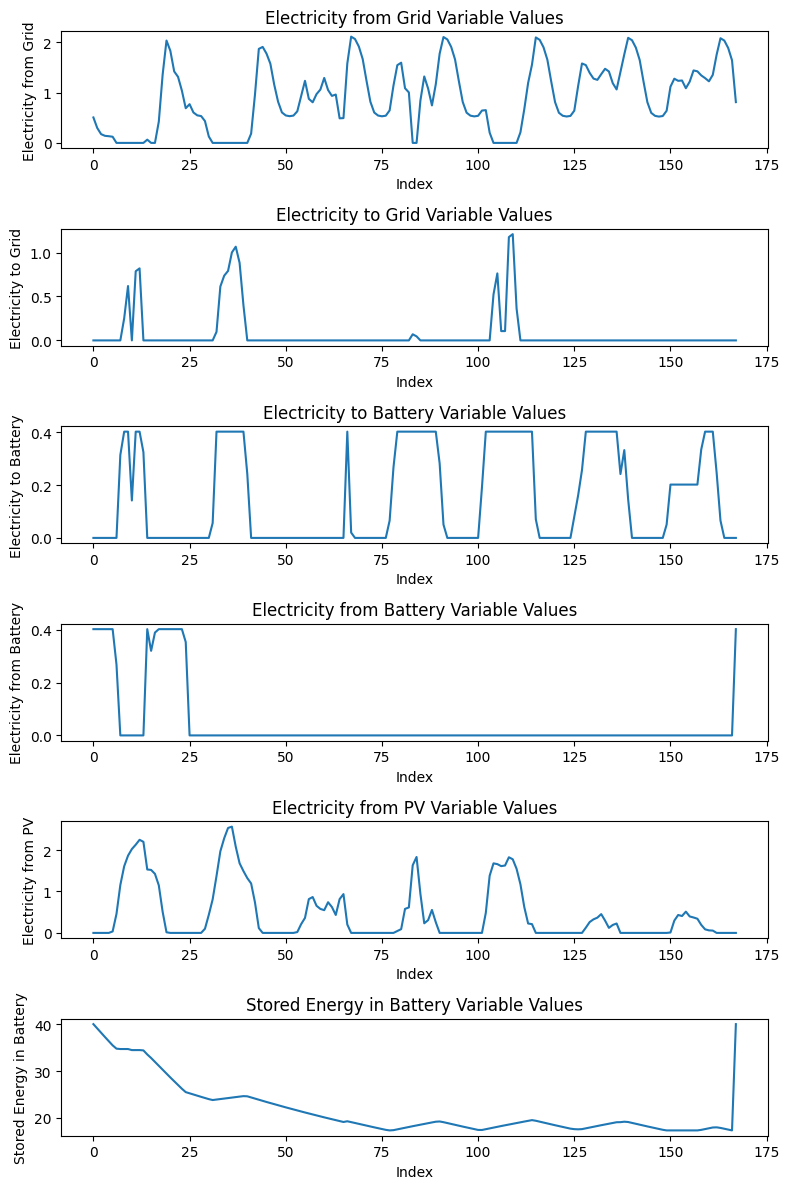

In [17]:
# Retrieve the variable objects
electricity_from_grid_var = [model.getVarByName(f"electricity_from_grid_to_demand[{i}]") for i in range(len(electricity_demand))]
electricity_to_grid_var = [model.getVarByName(f"electricity_from_pv_to_grid_feed_in[{i}]") for i in range(len(electricity_demand))]
electricity_to_batt_var = [model.getVarByName(f"electricity_from_pv_to_battery[{i}]") for i in range(len(electricity_demand))]
electricity_from_batt_var = [model.getVarByName(f"electricity_from_battery_to_demand[{i}]") for i in range(len(electricity_demand))]
electricity_from_pv_var = [model.getVarByName(f"electricity_from_pv_to_demand[{i}]") for i in range(len(electricity_demand))]
E_bat_var = [model.getVarByName(f"stored energy in bat[{i}]") for i in range(len(electricity_demand))]

# Retrieve the solution values for the variables
electricity_from_grid_values = model.getAttr("x", electricity_from_grid_var)
electricity_to_grid_values = model.getAttr("x", electricity_to_grid_var)
electricity_to_batt_values = model.getAttr("x", electricity_to_batt_var)
electricity_from_batt_values = model.getAttr("x", electricity_from_batt_var)
electricity_from_pv_values = model.getAttr("x", electricity_from_pv_var)
E_bat_values = model.getAttr("x", E_bat_var)

# Create an array of indices (assuming electricity_demand is available)
indices = np.arange(len(electricity_demand))

# Create subplots for each variable
fig, axs = plt.subplots(6, 1, figsize=(8, 12))

# Plot the values for electricity_from_grid
axs[0].plot(indices, electricity_from_grid_values)
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Electricity from Grid")
axs[0].set_title("Electricity from Grid Variable Values")

# Plot the values for electricity_to_grid
axs[1].plot(indices, electricity_to_grid_values)
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Electricity to Grid")
axs[1].set_title("Electricity to Grid Variable Values")

# Plot the values for electricity_to_batt
axs[2].plot(indices, electricity_to_batt_values)
axs[2].set_xlabel("Index")
axs[2].set_ylabel("Electricity to Battery")
axs[2].set_title("Electricity to Battery Variable Values")

# Plot the values for electricity_from_batt
axs[3].plot(indices, electricity_from_batt_values)
axs[3].set_xlabel("Index")
axs[3].set_ylabel("Electricity from Battery")
axs[3].set_title("Electricity from Battery Variable Values")

# Plot the values for electricity_from_pv
axs[4].plot(indices, electricity_from_pv_values)
axs[4].set_xlabel("Index")
axs[4].set_ylabel("Electricity from PV")
axs[4].set_title("Electricity from PV Variable Values")

# Plot the values for E_bat
axs[5].plot(indices, E_bat_values)
axs[5].set_xlabel("Index")
axs[5].set_ylabel("Stored Energy in Battery")
axs[5].set_title("Stored Energy in Battery Variable Values")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()